# Import Libraries

In [9]:
!pip install category_encoders
!pip install optuna

In [10]:
import numpy as np
import pandas as pd
import category_encoders as ce
import math
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import optuna
import lightgbm as lgb
import warnings
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,StandardScaler , RobustScaler

warnings.simplefilter(action='ignore', category=Warning)

# Exploratory Data Analysis (EDA)

In [11]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")
df_train

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,0x7c09,JAPRES04DEL01,30,4.8,26.902328,75.794257,26.912328,75.804257,24-03-2022,11:35:00,11:45:00,conditions Windy,High,1,Meal,motorcycle,0,No,Metropolitian,(min) 32
45589,0xd641,AGRRES16DEL01,21,4.6,0.000000,0.000000,0.070000,0.070000,16-02-2022,19:55:00,20:10:00,conditions Windy,Jam,0,Buffet,motorcycle,1,No,Metropolitian,(min) 36
45590,0x4f8d,CHENRES08DEL03,30,4.9,13.022394,80.242439,13.052394,80.272439,11-03-2022,23:50:00,00:05:00,conditions Cloudy,Low,1,Drinks,scooter,0,No,Metropolitian,(min) 16
45591,0x5eee,COIMBRES11DEL01,20,4.7,11.001753,76.986241,11.041753,77.026241,07-03-2022,13:35:00,13:40:00,conditions Cloudy,High,0,Snack,motorcycle,1,No,Metropolitian,(min) 26


In [12]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations(Gözlem): {dataframe.shape[0]}")
    print(f"Variables(Değişken): {dataframe.shape[1]}")
    print(f'cat_cols(kategorik Değişken): {len(cat_cols)}')
    print(f'num_cols(Numerik değişken): {len(num_cols)}')
    print(f'cat_but_car(Kardinal değişken): {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [13]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df_train)

Observations(Gözlem): 45593
Variables(Değişken): 20
cat_cols(kategorik Değişken): 8
num_cols(Numerik değişken): 4
cat_but_car(Kardinal değişken): 8
num_but_cat: 1


In [14]:
cat_but_car

['ID',
 'Delivery_person_ID',
 'Delivery_person_Age',
 'Delivery_person_Ratings',
 'Order_Date',
 'Time_Orderd',
 'Time_Order_picked',
 'Time_taken(min)']

In [15]:
df_train['Restaurant_latitude'].value_counts()

 0.000000     3640
 26.911378     182
 26.914142     180
 26.892312     176
 26.902940     176
              ... 
-23.355164       1
-15.513150       1
-22.311358       1
-27.161661       1
-12.978453       1
Name: Restaurant_latitude, Length: 657, dtype: int64

In [16]:
df_train["Weatherconditions"] = df_train["Weatherconditions"].str.replace("conditions", "")
df_train = df_train.replace('NaN ', np.nan)
df_train = df_train.replace(' NaN', np.nan)
df_train["Time_taken(min)"] = df_train["Time_taken(min)"].str.replace(r"\(min\)", "", regex = True)

df_test["Weatherconditions"] = df_test["Weatherconditions"].str.replace("conditions", "")
df_test = df_test.replace('NaN ', np.nan)
df_test = df_test.replace(' NaN', np.nan)



In [17]:
df_train.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,Sunny,High,2,Snack,motorcycle,0,No,Urban,24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,Cloudy,High,1,Snack,scooter,1,No,Metropolitian,30


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          43739 non-null  object 
 3   Delivery_person_Ratings      43685 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  43862 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            44977 non-null  object 
 12  Road_traffic_density         44992 non-null  object 
 13  Vehicle_conditio

In [19]:
df_train['Delivery_person_Ratings'] = df_train['Delivery_person_Ratings'].astype(float)
df_train['Delivery_person_Age'] = df_train['Delivery_person_Age'].astype(float)
df_train['Order_Date'] = pd.to_datetime(df_train['Order_Date'], format='%d-%m-%Y')
df_train['Time_Orderd'] = pd.to_datetime(df_train['Time_Orderd'], format='%H:%M:%S').dt.time
df_train['Time_Order_picked'] = pd.to_datetime(df_train['Time_Order_picked'], format='%H:%M:%S').dt.time
df_train['Time_taken(min)'] = df_train['Time_taken(min)'].astype(int)


df_test['Delivery_person_Ratings'] = df_test['Delivery_person_Ratings'].astype(float)
df_test['Delivery_person_Age'] = df_test['Delivery_person_Age'].astype(float)
df_test['Order_Date'] = pd.to_datetime(df_test['Order_Date'], format='%d-%m-%Y')
df_test['Time_Orderd'] = pd.to_datetime(df_test['Time_Orderd'], format='%H:%M:%S').dt.time
df_test['Time_Order_picked'] = pd.to_datetime(df_test['Time_Order_picked'], format='%H:%M:%S').dt.time


In [20]:
df_train.isnull().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions               616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken(min)                   0
dtype: int64

In [21]:
def show_dist(column):
  sns.distplot(column)
  print(f"'{column.name}' below is the distribution of the column:\nmedian:  {column.median()}\n{column.describe().T} ")

'Delivery_person_Age' sütununun dağılımı aşağıdadır:
median:  30.0
count    43739.000000
mean        29.567137
std          5.815155
min         15.000000
25%         25.000000
50%         30.000000
75%         35.000000
max         50.000000
Name: Delivery_person_Age, dtype: float64 


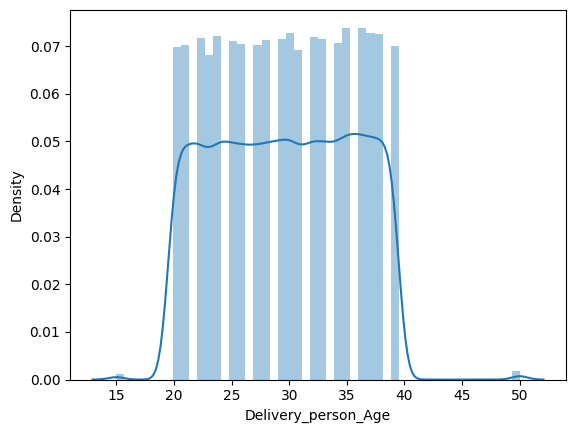

In [22]:
show_dist(df_train['Delivery_person_Age'])

'Delivery_person_Ratings' sütununun dağılımı aşağıdadır:
median:  4.7
count    43685.000000
mean         4.633780
std          0.334716
min          1.000000
25%          4.500000
50%          4.700000
75%          4.900000
max          6.000000
Name: Delivery_person_Ratings, dtype: float64 


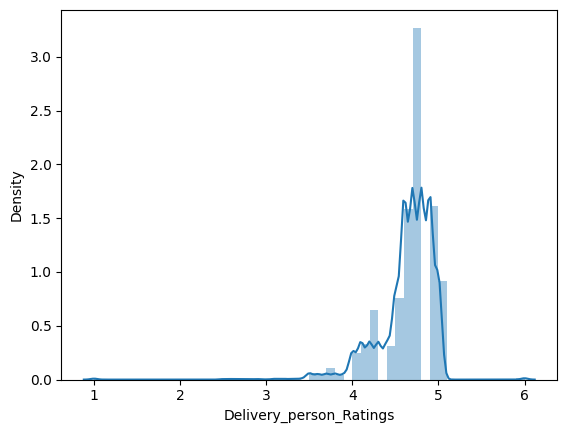

In [23]:
show_dist(df_train['Delivery_person_Ratings'])

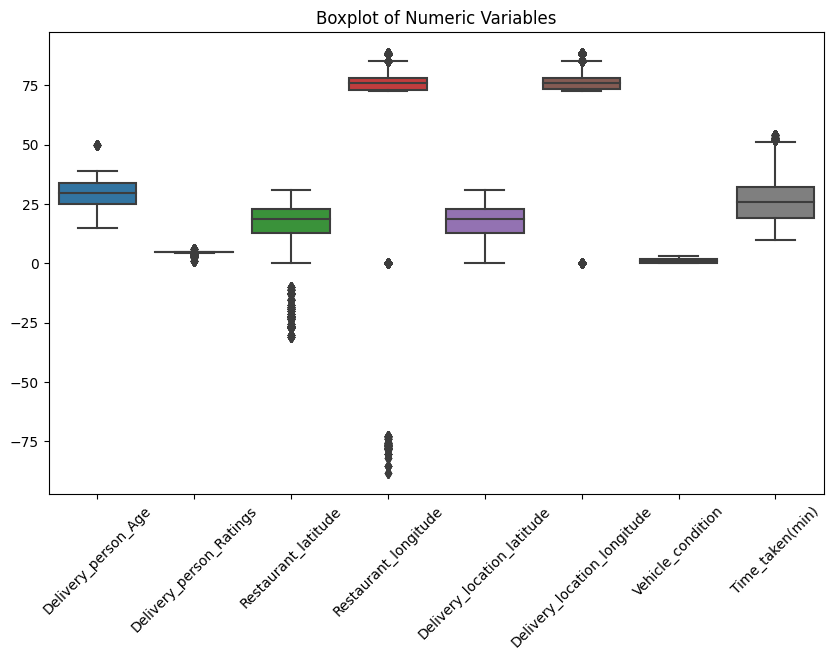

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train)
plt.title('Boxplot of Numeric Variables')
plt.xticks(rotation=45)
plt.show()

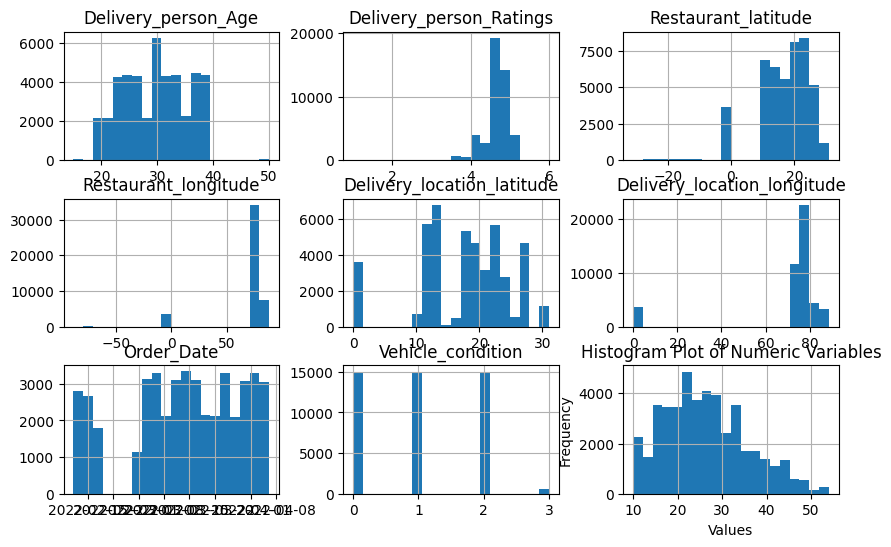

In [30]:
df_train.hist(bins=20, figsize=(10, 6))
plt.title('Histogram Plot of Numeric Variables')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [31]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Delivery_person_Age,45593.0,29.567137,5.695692,15.000000,25.000000,29.567137,34.000000,50.000000
Delivery_person_Ratings,45593.0,4.636552,0.327906,1.000000,4.600000,4.700000,4.800000,6.000000
Restaurant_latitude,45593.0,17.017729,8.185109,-30.905562,12.933284,18.546947,22.728163,30.914057
Restaurant_longitude,45593.0,70.231332,22.883647,-88.366217,73.170000,75.898497,78.044095,88.433452
Delivery_location_latitude,45593.0,17.465186,7.335122,0.010000,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45593.0,70.845702,21.118812,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45593.0,1.023359,0.839065,0.000000,0.000000,1.000000,2.000000,3.000000
Time_taken(min),45593.0,26.294607,9.383806,10.000000,19.000000,26.000000,32.000000,54.000000


# Missing Values

In [24]:
df_train['Delivery_person_Age'].fillna(df_train['Delivery_person_Age'].mean(), inplace=True)
df_test['Delivery_person_Age'].fillna(df_test['Delivery_person_Age'].mean(), inplace=True)

In [25]:
df_train['Delivery_person_Ratings'].fillna(df_train['Delivery_person_Ratings'].median(), inplace=True)
df_test['Delivery_person_Ratings'].fillna(df_test['Delivery_person_Ratings'].median(), inplace=True)

In [26]:
df_train['Festival'].fillna('No', inplace=True)
df_test['Festival'].fillna('No', inplace=True)

df_train['Road_traffic_density'].fillna('Low', inplace=True)
df_test['Road_traffic_density'].fillna('Low', inplace=True)

df_train['multiple_deliveries'].fillna('1', inplace=True)
df_test['multiple_deliveries'].fillna('1', inplace=True)

df_train['City'].fillna('Other', inplace=True)
df_test['City'].fillna('Other', inplace=True)


In [27]:
df_test.isnull().sum()

ID                               0
Delivery_person_ID               0
Delivery_person_Age              0
Delivery_person_Ratings          0
Restaurant_latitude              0
Restaurant_longitude             0
Delivery_location_latitude       0
Delivery_location_longitude      0
Order_Date                       0
Time_Orderd                    444
Time_Order_picked                0
Weatherconditions              158
Road_traffic_density             0
Vehicle_condition                0
Type_of_order                    0
Type_of_vehicle                  0
multiple_deliveries              0
Festival                         0
City                             0
dtype: int64

# Feature extraction

In [32]:
def time_period(clock):
    if 5 <= clock.hour < 12:
        return 'morning'
    elif 12 <= clock.hour < 17:
        return 'afternoon'
    elif 17 <= clock.hour < 20:
        return 'evening'
    else:
        return 'night'

df_train['Time_Period'] = df_train['Time_Order_picked'].apply(time_period)
df_test['Time_Period'] = df_test['Time_Order_picked'].apply(time_period)

In [33]:
def haversine_distance(data):
    R = 6371.0  # radius of the earth (km)
    lat1 = data['Restaurant_latitude']
    lon1 = data['Restaurant_longitude']
    lat2 = data['Delivery_location_latitude']
    lon2 = data['Delivery_location_longitude']

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)

    a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance


In [34]:
df_train['Restaurant_latitude'] = df_train['Restaurant_latitude'].apply(lambda x: abs(x))
df_train['Restaurant_longitude'] = df_train['Restaurant_longitude'].apply(lambda x: abs(x))

df_test['Delivery_location_latitude'] = df_test['Delivery_location_latitude'].apply(lambda x: abs(x))
df_test['Delivery_location_longitude'] = df_test['Delivery_location_longitude'].apply(lambda x: abs(x))

In [35]:
df_train['distance'] = df_train.apply(haversine_distance, axis=1)
df_test['distance'] = df_test.apply(haversine_distance, axis=1)

In [36]:
def season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'fall'
    else:
        return 'winter'

df_train['Season'] = df_train['Order_Date'].apply(season)
df_test['Season'] = df_test['Order_Date'].apply(season)

In [37]:
df_train['is_weekend'] = df_train['Order_Date'].dt.dayofweek // 5
df_test['is_weekend'] = df_test['Order_Date'].dt.dayofweek // 5

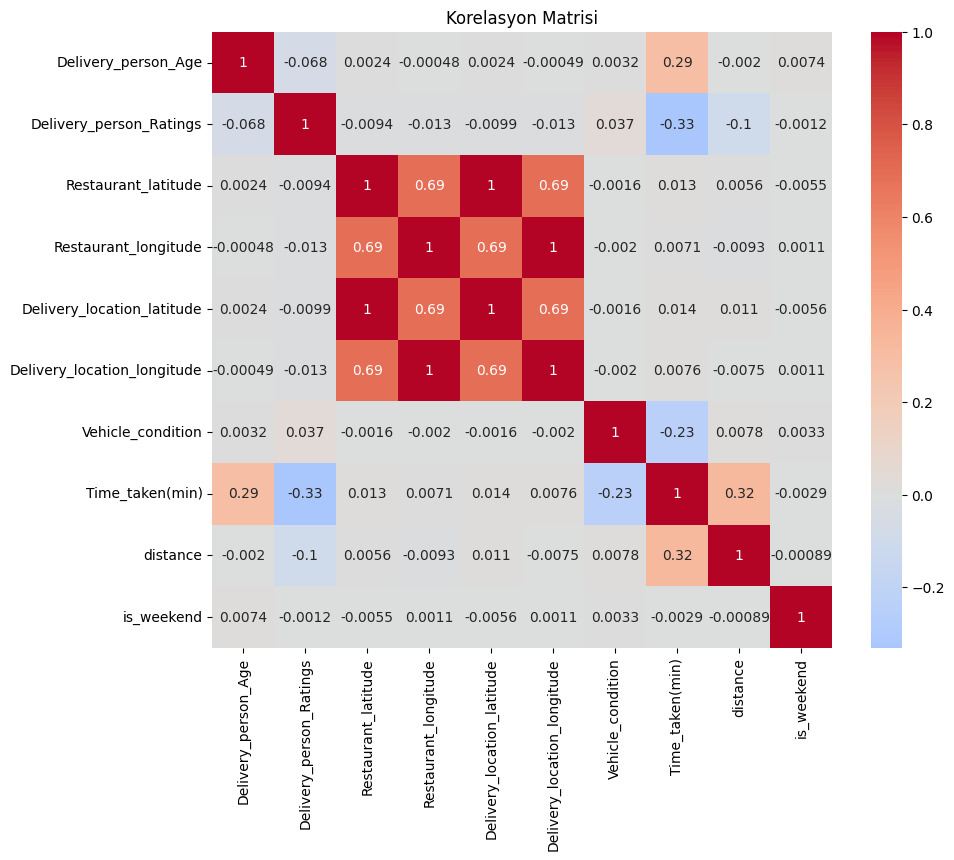

In [38]:
correlation_matrix = df_train.corr()

# Korelasyon matrisi için ısı haritası oluşturma
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Korelasyon Matrisi')
plt.show()

# Encoding

In [39]:
def one_hot_encode_columns(dataframe, columns_to_encode):
    """
    Apply One-Hot Encoding to specified columns in the DataFrame.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the columns to be encoded.
        columns_to_encode (list): List of column names to be One-Hot Encoded.

    Returns:
        pd.DataFrame: The DataFrame with specified columns One-Hot Encoded.
    """

    df_encoded = pd.get_dummies(dataframe, columns=columns_to_encode)
    return df_encoded

encoded_df = one_hot_encode_columns(df_train, columns_to_encode=['Time_Period', 'City', 'Season', 'Weatherconditions','Type_of_order'])
encoded_df_test = one_hot_encode_columns(df_test, columns_to_encode=['Time_Period', 'City', 'Season', 'Weatherconditions','Type_of_order'])

In [40]:
encoded_df['Type_of_vehicle'].unique()
encoded_df['Type_of_vehicle'].replace({'bicycle':0,'bicycle ':0 , 'electric_scooter ':1, 'scooter ':2 , 'motorcycle ': 3}, inplace=True)
encoded_df_test['Type_of_vehicle'].replace({'bicycle':0 ,'bicycle ':0, 'electric_scooter ':1, 'scooter ':2 , 'motorcycle ': 3}, inplace=True)

encoded_df['Type_of_vehicle'] = encoded_df['Type_of_vehicle'].astype(int)
encoded_df_test['Type_of_vehicle'] = encoded_df_test['Type_of_vehicle'].astype(int)

In [41]:
encoded_df['Road_traffic_density'].replace({'Low': 0, 'Low ':0 ,'High ':2, 'Jam ':3, 'Medium':1, 'Medium ':1}, inplace=True)
encoded_df_test['Road_traffic_density'].replace({'Low': 0, 'Low ':0 ,'High ':2, 'Jam ':3, 'Medium':1, 'Medium ':1}, inplace=True)

encoded_df['Road_traffic_density'] = encoded_df['Road_traffic_density'].astype(int)
encoded_df_test['Road_traffic_density'] = encoded_df_test['Road_traffic_density'].astype(int)

In [42]:
encoded_df['Festival'].replace({'No':0, 'No ':0, 'Yes ':1}, inplace= True)
encoded_df_test['Festival'].replace({'No':0, 'No ':0, 'Yes ':1}, inplace= True)

In [43]:
encoded_df['multiple_deliveries'] = encoded_df['multiple_deliveries'].astype(int)
encoded_df_test['multiple_deliveries'] = encoded_df_test['multiple_deliveries'].astype(int)

In [44]:
encoded_df.drop(columns=['ID', 'Delivery_person_ID','Time_Orderd','Time_Order_picked','Order_Date'], inplace = True)
encoded_df_test.drop(columns=['ID', 'Delivery_person_ID','Time_Orderd','Time_Order_picked','Order_Date'], inplace = True)

In [45]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Delivery_person_Age            45593 non-null  float64
 1   Delivery_person_Ratings        45593 non-null  float64
 2   Restaurant_latitude            45593 non-null  float64
 3   Restaurant_longitude           45593 non-null  float64
 4   Delivery_location_latitude     45593 non-null  float64
 5   Delivery_location_longitude    45593 non-null  float64
 6   Road_traffic_density           45593 non-null  int64  
 7   Vehicle_condition              45593 non-null  int64  
 8   Type_of_vehicle                45593 non-null  int64  
 9   multiple_deliveries            45593 non-null  int64  
 10  Festival                       45593 non-null  int64  
 11  Time_taken(min)                45593 non-null  int64  
 12  distance                       45593 non-null 

# Scaling

In [58]:
# Import features into a separate dataframe (including only features)
features = encoded_df.drop('Time_taken(min)', axis=1)

# Create scaler
scaler = RobustScaler()

# Scale features
scaled_features = scaler.fit_transform(features)

# Create scaled_df
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# Add the "Target" column to scaled_df
scaled_df['Time_taken(min)'] = encoded_df['Time_taken(min)']

scaled_df

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,...,Weatherconditions_ Fog,Weatherconditions_ Sandstorms,Weatherconditions_ Stormy,Weatherconditions_ Sunny,Weatherconditions_ Windy,Type_of_order_Buffet,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack,Time_taken(min)
0,0.825874,1.0,0.427704,-0.001236,0.421689,-0.018666,0.333333,0.5,0.0,-1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,24
1,0.492540,-1.0,-0.575762,0.366039,-0.570698,0.375108,0.666667,0.5,-1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,33
2,-0.729682,-1.5,-0.575637,0.365047,-0.582822,0.349246,-0.333333,-0.5,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26
3,0.936985,0.0,-0.770635,0.221090,-0.773765,0.212122,0.000000,-0.5,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,21
4,0.270318,-0.5,-0.569663,0.892462,-0.573785,0.888206,0.333333,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,0.048096,0.5,0.852001,-0.021379,0.845028,-0.041085,0.333333,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,32
45589,-0.951904,-0.5,-1.893682,-15.566295,-1.894937,-15.730657,0.666667,-0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,36
45590,0.048096,1.0,-0.564601,0.890915,-0.569743,0.884571,-0.333333,0.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,16
45591,-1.063015,0.0,-0.770830,0.223089,-0.774982,0.212069,0.333333,-0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26


In [57]:
# Import features into a separate dataframe (including only features)
features = encoded_df_test

# Scale features
scaled_features = scaler.fit_transform(features)

# Create scaled_df
scaled_df_test = pd.DataFrame(scaled_features, columns=features.columns)


# Modelling

In [47]:
# Separate features and target variable
features = scaled_df.drop('Time_taken(min)', axis=1)
target = scaled_df['Time_taken(min)']

# Train - test split
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, random_state=42, stratify=scaled_df['Time_taken(min)'])

print("Train data (X_train):\n", X_train)
print("Test data (X_test):\n", X_valid)
print("Train target (y_train):\n", y_train)
print("Test target (y_test):\n", y_valid)

Eğitim verisi (X_train):
        Delivery_person_Age  Delivery_person_Ratings  Restaurant_latitude  \
12993             0.936985                     -1.0             0.265986   
7149              0.492540                     -1.5             0.068326   
40572            -0.618571                     -0.5             0.491997   
34446             0.159207                      0.0             0.490406   
7965             -0.396349                      0.0            -0.003895   
...                    ...                      ...                  ...   
5113              0.603651                      0.5            -0.635962   
19034             0.048096                     -1.0             0.852001   
23263             0.000000                      0.0            -0.000829   
13599             0.714763                      0.0            -0.634857   
36254             0.000000                      0.0            -0.003507   

       Restaurant_longitude  Delivery_location_latitude  \
12

In [48]:

# We create the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# We train the model
model.fit(X_train, y_train)

# Making predictions on test data
predictions = model.predict(X_valid)

# Calculate error value
mse = mean_squared_error(y_valid, predictions)

# Calculate the R-squared value
r2 = r2_score(y_valid, predictions)

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_valid, predictions))

print("R-kare Değeri:", r2)
print("RMSE Değeri:", rmse)
print("Mean Squared Error:", mse)

R-kare Değeri: 0.8213394317384681
RMSE Değeri: 3.965334850949168
Mean Squared Error: 15.723880480152062


# Optimization

In [49]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'lambda': trial.suggest_float('lambda', 1e-6, 10, log=True)
    }

    model = xgb.XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    r2 = r2_score(y_valid, predictions)
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("En iyi hiperparametre kombinasyonu:", study.best_params)
print("En iyi R2 score değeri:", study.best_value)

[I 2023-08-28 17:33:34,141] A new study created in memory with name: no-name-669668d2-2317-48ae-95f9-f347cf528072
[I 2023-08-28 17:33:45,904] Trial 0 finished with value: 0.7860032112110407 and parameters: {'n_estimators': 119, 'learning_rate': 0.03186647012694732, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.5083290975729133, 'colsample_bytree': 0.83107544744805, 'lambda': 1.601122894438368}. Best is trial 0 with value: 0.7860032112110407.
[I 2023-08-28 17:33:48,200] Trial 1 finished with value: 0.7963246955971177 and parameters: {'n_estimators': 78, 'learning_rate': 0.21941458866783956, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8965852490061768, 'colsample_bytree': 0.6361111996500457, 'lambda': 0.26306676215032415}. Best is trial 1 with value: 0.7963246955971177.
[I 2023-08-28 17:34:03,593] Trial 2 finished with value: 0.8190741849799035 and parameters: {'n_estimators': 129, 'learning_rate': 0.2373215421852817, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 

En iyi hiperparametre kombinasyonu: {'n_estimators': 88, 'learning_rate': 0.07140558160691693, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8880061652630831, 'colsample_bytree': 0.9233889166320962, 'lambda': 7.3548851373085125}
En iyi R2 score değeri: 0.8322183438216402


# Best Model

In [50]:
best_params = study.best_params
# We create the XGBoost model
best_model = xgb.XGBRegressor(**best_params, random_state=42)

# We train the model
best_model.fit(X_train, y_train)

# Making predictions on test data
predictions = best_model.predict(X_valid)

# Calculate error value
mse = mean_squared_error(y_valid, predictions)

# Calculate the R-squared value
r2 = r2_score(y_valid, predictions)

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_valid, predictions))

print("R-kare Değeri:", r2)
print("RMSE Değeri:", rmse)
print("Mean Squared Error:", mse)

R-kare Değeri: 0.8322183438216402
RMSE Değeri: 3.8427112339957836
Mean Squared Error: 14.766429627877399


In [51]:
(y_valid-predictions).describe().T

count    9119.000000
mean        0.092154
std         3.841817
min       -17.422432
25%        -2.670523
50%        -0.041063
75%         2.621681
max        23.382988
Name: Time_taken(min), dtype: float64

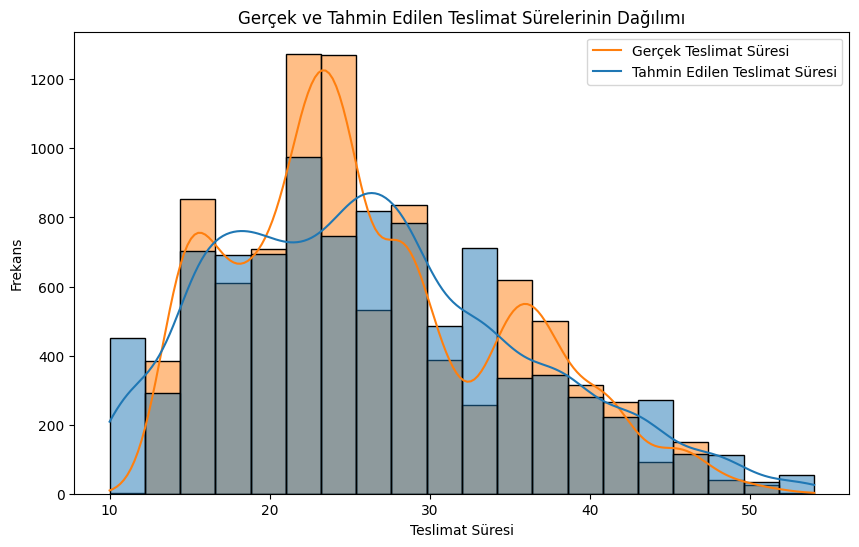

In [52]:
dist_pred_real = pd.DataFrame({'Gerçek Teslimat Süresi': y_valid, 'Tahmin Edilen Teslimat Süresi': predictions})

# Dağılım grafiğini oluşturun
plt.figure(figsize=(10, 6))
sns.histplot(data=dist_pred_real, bins=20, kde=True)  # kde=True ile yoğunluk tahminini de göster
plt.xlabel('Teslimat Süresi')
plt.ylabel('Frekans')
plt.title('Gerçek ve Tahmin Edilen Teslimat Sürelerinin Dağılımı')
plt.legend(['Gerçek Teslimat Süresi', 'Tahmin Edilen Teslimat Süresi'])
plt.show()

# Submission

In [59]:
test_predictions = best_model.predict(scaled_df_test)

In [60]:
submission = pd.DataFrame()
submission["ID"]=df_test["ID"]
submission["Time_taken (min)"] = test_predictions

In [61]:
submission.to_csv('submission.csv', index=False)